# How Many Typos?

When I started a new job at [Brilliant](https://brilliant.org) a couple of weeks ago, I learned that one of my new colleagues, Michelle McSweeney, just published [a book called *OK*](https://www.goodreads.com/book/show/58380165-ok), which is all about the word OK.

As we discussed the joys and miseries of publishing, Michelle mentioned that she had found a typo in the book after publication.
So naturally I took it as a challenge to find the typo.
While I was searching, I enjoyed the book very much. If you are interested in etymology, linguistics, and history, I recommend it!

And, as it turned out, I found exactly one typo. When I told Michelle, she asked me nervously which page it was on. Page 17. She looked disappointed -- that was not the same typo she found.

Now, for people who like Bayesian statistics, this scenario raises some questions:

1) After our conversation, how many additional typos should we expect there to be?

2) If she and I had found the same typo, instead of different ones, how many typos would we expect?

As it happens, I used similar scenario as [an example in *Think Bayes*](https://allendowney.github.io/ThinkBayes2/chap15.html#the-lincoln-index-problem). This notebook is based on the code I presented there. If there's anything here that's not clear, you could read the chapter for more details.

[You can also click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ThinkBayes2/blob/master/examples/vaccine2.ipynb).

In [1]:
# If we're running on Colab, install empiricaldist
# https://pypi.org/project/empiricaldist/

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

In [2]:
# Get utils.py

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ThinkBayes2/raw/master/soln/utils.py')

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import decorate

## A warmup problem

To represent the data, I'll create these variables:

* `k10`: the number of typos found by the first reader but not the second
* `k01`: the number of typos found by the second reader but not the first
* `k11`: the number of typos found by both readers

In [4]:
k10 = 1
k01 = 1
k11 = 0

Starting with a simple version of the problem, let's assume that we know `p0` and `p1`, which are the probabilities, respectively, that the first and second readers find any given typo.

For example, let's assume that Michelle has a 66% chance of finding a typo and I have a 50% chance.

In [5]:
p0, p1 = 0.66, 0.5

With these assumptions, we can compute an array that contains (in order) the probability that neither of us find a typo, the probability that only the second reader does, the probability that the first reader does, and the probability that we both do.

In [6]:
def compute_probs(p0, p1):
    """Computes the probability for each of 4 categories."""
    q0 = 1-p0
    q1 = 1-p1
    return [q0*q1, q0*p1, p0*q1, p0*p1]

In [7]:
y = compute_probs(p0, p1)
y

[0.16999999999999998, 0.16999999999999998, 0.33, 0.33]

With these probabilities, there is a 33% chance that we both find a typo and a 17% chance that neither of us do.

## The Prior

Next we need to choose a prior for the total number of typos. I'll use a Poisson distribution, which is a reasonable default for a count. And I'll set the mean to 2, which means that before either of us read the book, I would have expected about two typos.

In [8]:
from utils import make_poisson_pmf

qs = np.arange(0, 11) 
lam = 2
prior_N = make_poisson_pmf(lam, qs)
prior_N.index.name = 'N'
prior_N.mean()

1.9999236196641172

Here's what the prior looks like.

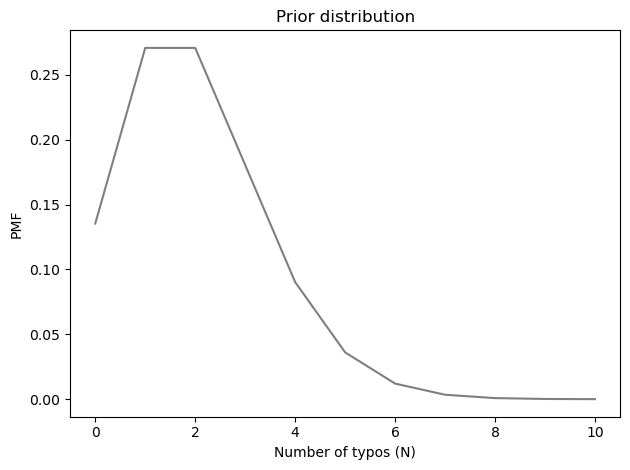

In [9]:
prior_N.plot(color='C7')

decorate(xlabel='Number of typos (N)',
         ylabel='PMF',
         title='Prior distribution')

## The Update (Simple Version)

I'll put the data in an array, with 0 as a place-keeper for the unknown value `k00`, which is the number of typos neither of us found.

In [10]:
data = np.array([0, k01, k10, k11])

Now we can use the multinomial distribution to compute the likelihood of the data for each hypothetical value of `N` (assuming for now that the probabilities in `y` are known).

In [11]:
from scipy.stats import multinomial

likelihood = prior_N.copy()
observed = data.sum()
x = data.copy()

for N in prior_N.qs:
    x[0] = N - observed
    likelihood[N] = multinomial.pmf(x, N, y)

We can compute the posterior in the usual way.

In [12]:
posterior_N = prior_N * likelihood
posterior_N.normalize()

0.0426675416210306

And here's what it looks like.

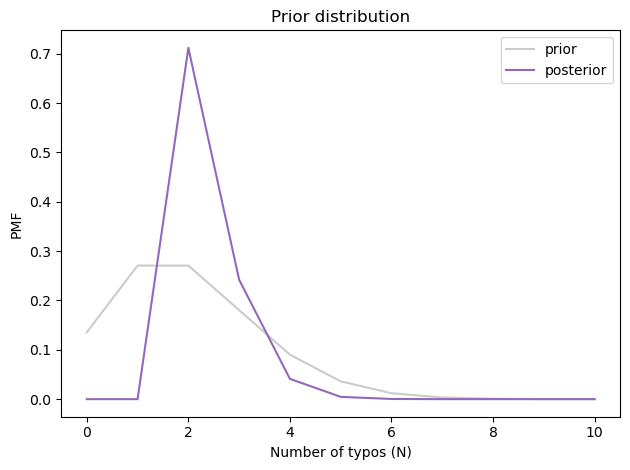

In [13]:
prior_N.plot(color='C7', alpha=0.4, label='prior')
posterior_N.plot(color='C4', label='posterior')

decorate(xlabel='Number of typos (N)',
         ylabel='PMF',
         title='Prior distribution')

In [14]:
print(posterior_N.mean(), 
      posterior_N.credible_interval(0.9))

2.3399999989281604 [2. 3.]


The posterior mean is about 2.3, just a little higher than the prior mean. So that's not bad. But remember that this is based on the assumption that we know `p0` and `p1`. In reality, they are unknown, but we can estimate them from the data.

## Three-Parameter Model

What we need is a model with three parameters: `N`, `p0`, and `p1`.
We'll use `prior_N` again for the prior distribution of `N`, and here are the priors for `p0` and `p1`:

In [15]:
from empiricaldist import Pmf
from scipy.stats import beta as beta_dist

def make_beta(qs, alpha, beta, name=""):
    ps = beta_dist.pdf(qs, alpha, beta)
    pmf = Pmf(ps, qs)
    pmf.normalize()
    pmf.index.name = name
    return pmf

In [16]:
qs = np.linspace(0, 1, num=51)
prior_p0 = make_beta(qs, 3, 2, name='p0')
prior_p1 = make_beta(qs, 2, 2, name='p1')

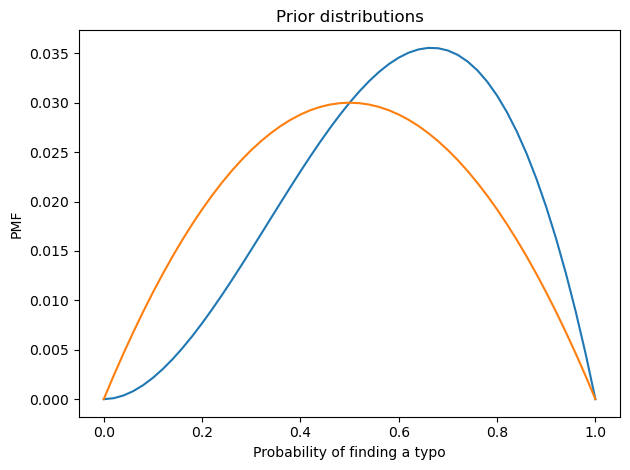

In [17]:
prior_p0.plot()
prior_p1.plot()

decorate(xlabel='Probability of finding a typo',
         ylabel='PMF',
         title='Prior distributions')

I used beta distributions to construct weakly informative priors for `p0` and `p1`, with means `0.66` and `0.5` respectively.

## The Joint Prior

Now we have to assemble them into a joint prior with three dimensions.
I'll start by putting the first two into a `DataFrame`.

In [18]:
from utils import make_joint

joint2 = make_joint(prior_p0, prior_N)
joint2.shape

(11, 51)

Now I'll stack them and put the result in a `Pmf`.

In [19]:
joint2_pmf = Pmf(joint2.stack())
joint2_pmf.head(3)

N  p0  
0  0.00    0.000000
   0.02    0.000013
   0.04    0.000050
Name: , dtype: float64

We can use `make_joint` again to add in the third parameter.

In [20]:
joint3 = make_joint(prior_p1, joint2_pmf)
joint3.shape

(561, 51)

The result is a `DataFrame` with values of `N` and `p0` in a `MultiIndex` that goes down the rows and values of `p1` in an index that goes across the columns.

In [21]:
joint3.head(3)

p1      0.00          0.02          0.04          0.06          0.08  \
N p0                                                                   
0 0.00   0.0  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
  0.02   0.0  2.997069e-08  5.871809e-08  8.624220e-08  1.125430e-07   
  0.04   0.0  1.174362e-07  2.300791e-07  3.379286e-07  4.409848e-07   

p1              0.10          0.12          0.14          0.16          0.18  \
N p0                                                                           
0 0.00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
  0.02  1.376205e-07  1.614748e-07  1.841057e-07  2.055133e-07  2.256977e-07   
  0.04  5.392478e-07  6.327174e-07  7.213937e-07  8.052767e-07  8.843664e-07   

p1      ...          0.82          0.84          0.86          0.88  \
N p0    ...                                                           
0 0.00  ...  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
  0.02  ...  2.256977e-07  2.055133e-07  1.841057e-07  1.614748e-07   
  0.04  ...  8.843664e-07  8.052767e-07  7.213937e-07  6.327174e-07   

p1              0.90          0.92          0.94          0.96          0.98  \
N p0                                                                           
0 0.00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
  0.02  1.376205e-07  1.125430e-07  8.624220e-08  5.871809e-08  2.997069e-08   
  0.04  5.392478e-07  4.409848e-07  3.379286e-07  2.300791e-07  1.174362e-07   

p1      1.00  
N p0          
0 0.00   0.0  
  0.02   0.0  
  0.04   0.0  

[3 rows x 51 columns]

Now I'll apply `stack` again:

In [22]:
joint3_pmf = Pmf(joint3.stack())
joint3_pmf.head(3)

N  p0   p1  
0  0.0  0.00    0.0
        0.02    0.0
        0.04    0.0
Name: , dtype: float64

The result is a `Pmf` with a three-column `MultiIndex` containing all possible triplets of parameters.

The number of rows is the product of the number of values in all three priors:

In [23]:
joint3_pmf.shape

(28611,)

That's still small enough to be practical, but it will take longer to compute the likelihoods than in the previous examples.

Here's the loop that computes the likelihoods; it's similar to the one in the previous section:

In [24]:
likelihood = joint3_pmf.copy()
observed = data.sum()
x = data.copy()

for N, p0, p1 in joint3_pmf.index:
    x[0] = N - observed
    y = compute_probs(p0, p1)
    likelihood[N, p0, p1] = multinomial.pmf(x, N, y)

/home/downey/miniconda3/envs/ThinkBayes2/lib/python3.10/site-packages/scipy/stats/_multivariate.py:3190: RuntimeWarning: invalid value encountered in subtract
  return gammaln(n+1) + np.sum(xlogy(x, p) - gammaln(x+1), axis=-1)


We can compute the posterior in the usual way.

In [25]:
posterior_pmf = joint3_pmf * likelihood
posterior_pmf.normalize()

0.03437554251769621

Now, to extract the marginal distributions, we could unstack the joint posterior as we did in the previous section.
But `Pmf` provides a version of `marginal` that works with a `Pmf` rather than a `DataFrame`.
Here's how we use it to get the posterior distribution for `N`.

In [26]:
posterior_N = posterior_pmf.marginal(0)

And here's what it looks like.

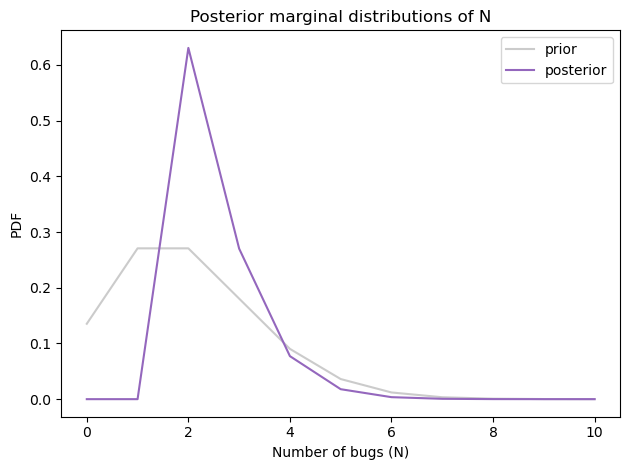

In [27]:
prior_N.plot(color='C7', alpha=0.4, label='prior')
posterior_N.plot(color='C4', label='posterior')

decorate(xlabel='Number of bugs (N)',
         ylabel='PDF',
         title='Posterior marginal distributions of N')

To compute the probability that there is at least one undiscovered typo, we can convert the posterior distribution to a survival function (complementary CDF):

In [28]:
posterior_N.make_surv()[observed]

0.369576444173048

The probability is less than 40% that there's another typo -- so that's good news!

The posterior mean is about 2.5, which is a little higher than what we got with the simple model.

In [29]:
posterior_N.mean()

2.4963989774563107

Apparently our uncertainty about `p0` and `p1` leaves open the possibility that there are more typos and we are not very good at finding them.
Here's what the posterior distributions look like for `p0` and `p1`. 

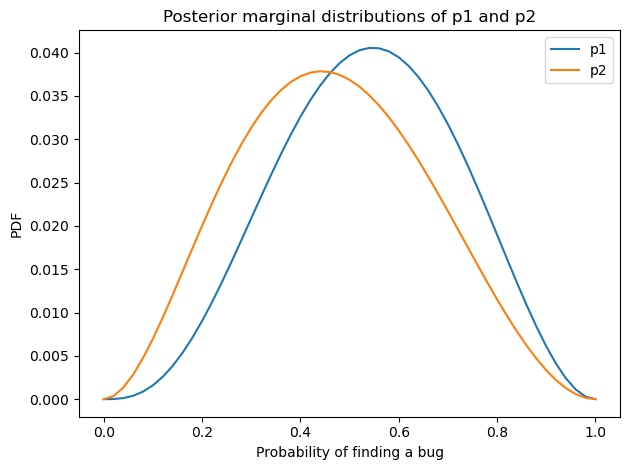

In [30]:
posterior_p1 = posterior_pmf.marginal(1)
posterior_p2 = posterior_pmf.marginal(2)

posterior_p1.plot(label='p1')
posterior_p2.plot(label='p2')

decorate(xlabel='Probability of finding a bug',
         ylabel='PDF',
         title='Posterior marginal distributions of p1 and p2')

With so little data, the posterior distributions are still quite wide, but the posterior means are a little smaller than the priors.

In [31]:
posterior_p1.mean(), posterior_p1.credible_interval(0.9)

(0.5383375553393667, array([0.24, 0.82]))

In [32]:
posterior_p2.mean(), posterior_p2.credible_interval(0.9)

(0.46718395159883724, array([0.16, 0.78]))

The fact that Michelle and I found only two typos is weak evidence that we are not as good at finding them as the priors implied.

At this point, we've answered the first question: given that Michelle and I found different bugs, the expected value for the number of remaining typos is about 0.5.

In the counterfactual case, if we had found the same typo, we can set `k11 = 1`, and run the analysis again. In that case, the expected number of remaining typos would be 0.3, and there would be only a 25% chance that there is more than one.

This notebook is based on [this chapter of *Think Bayes*, Second Edition](https://allendowney.github.io/ThinkBayes2/chap15.html#the-lincoln-index-problem).

Copyright 2023 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)